**Final Project - AI generated image vs Real image**

Obejcetive : Researchers and developers can leverage the dataset to train machine learning models for image classification and recognition tasks. By incorporating both web-scraped and AI-generated images, models can learn to identify and categorize objects, scenes, and concepts across diverse domains with greater accuracy and generalization.

[Dataset](https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images)

In [112]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [90]:
# Define paths of data 
aiart_data_path = "C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/AiArtData"
realart_data_path = "C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/RealArt"

In [91]:
# data preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [92]:
# Create datasets
aiart_dataset = ImageFolder(root=aiart_data_path, transform=data_transform)
realart_dataset = ImageFolder(root=realart_data_path, transform=data_transform)
# Create data loaders
batch_size = 32
aiart_loader = DataLoader(aiart_dataset, batch_size=batch_size, shuffle=True)
realart_loader = DataLoader(realart_dataset, batch_size=batch_size, shuffle=True)

**Exploratory data analysis**

In [93]:
# list of classes
aiart_classes = aiart_dataset.classes
realart_classes = realart_dataset.classes
# number of classes
num_aiart_classes = len(aiart_classes)
num_realart_classes = len(realart_classes)
# number of images 
num_aiart_images = [len(os.listdir(os.path.join(aiart_data_path, cls))) for cls in aiart_classes]
num_realart_images = [len(os.listdir(os.path.join(realart_data_path, cls))) for cls in realart_classes]
print("Number of classes in AiArtData:", num_aiart_classes)
print("Number of classes in RealArtData:", num_realart_classes)
print("\nNumber of images in each class in AiArtData:")
for cls, num_images in zip(aiart_classes, num_aiart_images):
    print(f"{cls}: {num_images} images")
print("\nNumber of images in each class in RealArtData:")
for cls, num_images in zip(realart_classes, num_realart_images):
    print(f"{cls}: {num_images} images")

Number of classes in AiArtData: 1
Number of classes in RealArtData: 1

Number of images in each class in AiArtData:
AiArt: 536 images

Number of images in each class in RealArtData:
RealArt: 435 images


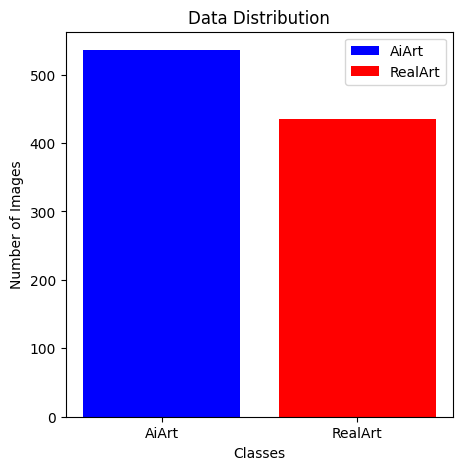

In [94]:
# data distribution
plt.figure(figsize=(5, 5))
plt.bar(aiart_classes, num_aiart_images, color='b', label='AiArt')
plt.bar(realart_classes, num_realart_images, color='r', label='RealArt')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Data Distribution')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

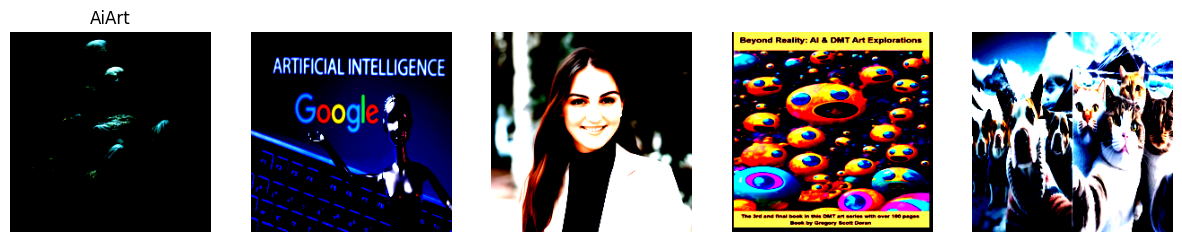

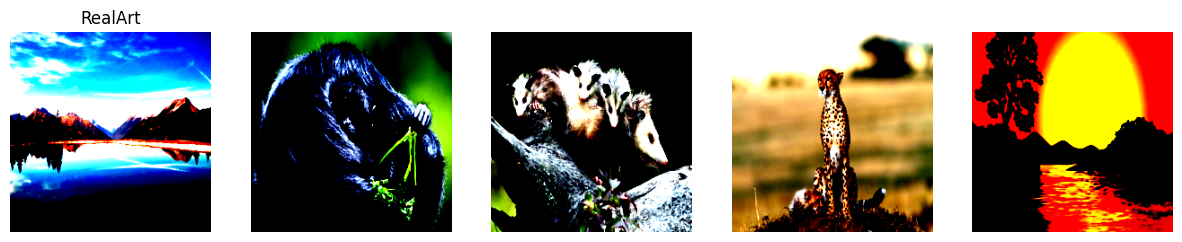

In [95]:
def show_samples(dataset, num_samples=5):
    classes = dataset.classes
    if len(classes) == 1:
        class_indices = [idx for idx in range(len(dataset))]
        sample_indices = random.sample(class_indices, num_samples)
        fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
        for j, idx in enumerate(sample_indices):
            image, _ = dataset[idx]
            axs[j].imshow(image.permute(1, 2, 0))
            axs[j].axis('off')
        axs[0].set_title(classes[0])
    else:
        fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 8))
        for i, cls in enumerate(classes):
            class_indices = [idx for idx, label in enumerate(dataset.targets) if label == i]
            sample_indices = random.sample(class_indices, num_samples)
            for j, idx in enumerate(sample_indices):
                image, _ = dataset[idx]
                axs[i, j].imshow(image.permute(1, 2, 0))
                axs[i, j].axis('off')
                if j == 0:
                    axs[i, j].set_title(cls)
        # Adjust spacing
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
# samples for AiArtData
show_samples(aiart_dataset)
# samples for RealArtData
show_samples(realart_dataset)

Convolutional Neural Networks

In [96]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
custom_model = CustomModel()

c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


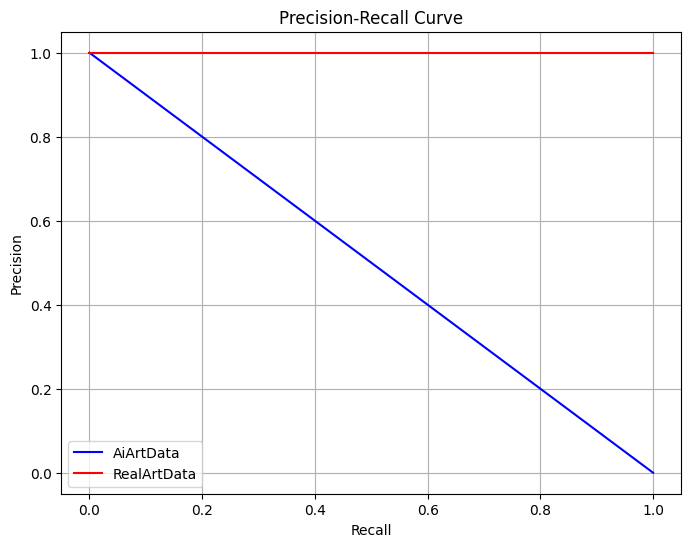

In [97]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
aiart_dataset = ImageFolder(root="C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/AiArtData", transform=transform)
realart_dataset = ImageFolder(root="C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/RealArt", transform=transform)
aiart_loader = DataLoader(aiart_dataset, batch_size=32, shuffle=False)
realart_loader = DataLoader(realart_dataset, batch_size=32, shuffle=False)
# predictions from the model
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            outputs = model(images)
            preds = torch.round(outputs) 
            predictions.extend(preds.tolist())
    return predictions
custom_model = CustomModel()
# predictions 
aiart_predictions = get_predictions(custom_model, aiart_loader)
realart_predictions = get_predictions(custom_model, realart_loader)
# ground truth labels for complete dataset
aiart_labels = [0] * len(aiart_predictions) 
realart_labels = [1] * len(realart_predictions) 
# precision and recall for each dataset
precision_aiart, recall_aiart, _ = precision_recall_curve(aiart_labels, aiart_predictions)
precision_realart, recall_realart, _ = precision_recall_curve(realart_labels, realart_predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_aiart, precision_aiart, label='AiArtData', color='blue')
plt.plot(recall_realart, precision_realart, label='RealArtData', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

VGG 16

In [98]:
# VGG model
class VGGModel(nn.Module):
    def __init__(self, num_classes=1):
        super(VGGModel, self).__init__()
        self.vgg = models.vgg16(pretrained=True)  
        # Freeze all layers
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg.classifier[-1] = nn.Linear(4096, num_classes)
    def forward(self, x):
        return self.vgg(x)
vgg_model = VGGModel(num_classes=1)

c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


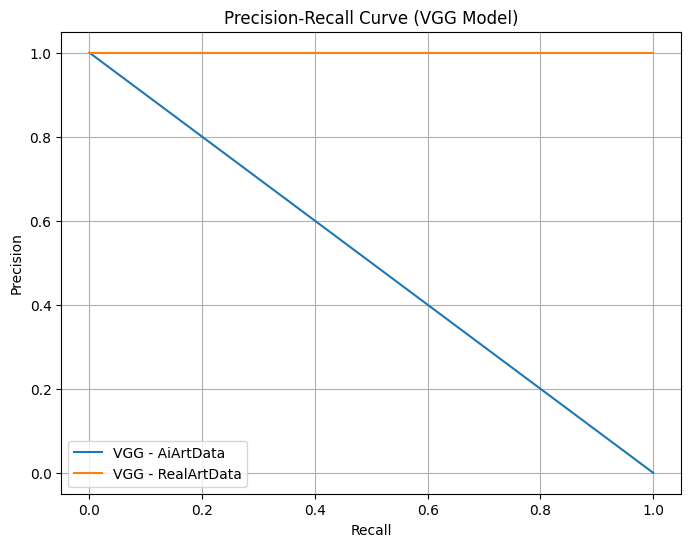

In [99]:
# predictions from the model
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            outputs = model(images)
            preds = torch.round(torch.sigmoid(outputs))  
            predictions.extend(preds.tolist())
    return predictions
vgg_aiart_predictions = get_predictions(vgg_model, aiart_loader)
vgg_realart_predictions = get_predictions(vgg_model, realart_loader)
# precision and recall dataset using VGG model
precision_vgg_aiart, recall_vgg_aiart, _ = precision_recall_curve(aiart_labels, vgg_aiart_predictions)
precision_vgg_realart, recall_vgg_realart, _ = precision_recall_curve(realart_labels, vgg_realart_predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_vgg_aiart, precision_vgg_aiart, label='VGG - AiArtData')
plt.plot(recall_vgg_realart, precision_vgg_realart, label='VGG - RealArtData')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (VGG Model)')
plt.legend()
plt.grid(True)
plt.show()

Fine-tune VGG16 

In [100]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
aiart_dataset = ImageFolder(root="C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/AiArtData", transform=transform)
realart_dataset = ImageFolder(root="C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/RealArt", transform=transform)
aiart_loader = DataLoader(aiart_dataset, batch_size=32, shuffle=True)
realart_loader = DataLoader(realart_dataset, batch_size=32, shuffle=True)
# pre-trained VGG16 
vgg16 = models.vgg16(pretrained=True)
# Freeze layers
for param in vgg16.parameters():
    param.requires_grad = False
num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_features, 1)
# device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device
vgg16 = vgg16.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)
# Train the fine-tuned model
for epoch in range(10):
    vgg16.train()
    running_loss = 0.0
    for images, labels in aiart_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(aiart_loader.dataset)
    print(f"Epoch [{epoch + 1}/10], Loss: {epoch_loss:.4f}")

# Saved fine-tuned model
torch.save(vgg16.state_dict(), "fine_tuned_vgg16.pth")

c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 0.0863
Epoch [2/10], Loss: 0.0004
Epoch [3/10], Loss: 0.0002
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001


In [101]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
aiart_dataset = ImageFolder(root="C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/AiArtData", transform=transform)
realart_dataset = ImageFolder(root="C:/Users/Abdul/CSCN8010_Labs/Data/FP_data/RealArt", transform=transform)
# Split the dataset
aiart_train_data, aiart_test_data = train_test_split(aiart_dataset, test_size=0.2, random_state=42)
realart_train_data, realart_test_data = train_test_split(realart_dataset, test_size=0.2, random_state=42)
# Create data loaders
train_loader = DataLoader(aiart_train_data + realart_train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(aiart_test_data + realart_test_data, batch_size=32, shuffle=False)
custom_model = CustomModel()
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)
# variables to track the best model
best_accuracy = 0.0
best_model_path = 'best_model.pth'
# Train the model
for epoch in range(10):
    custom_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = custom_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    custom_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = custom_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/10], Test Accuracy: {accuracy:.4f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(custom_model.state_dict(), best_model_path)

Epoch [1/10], Test Accuracy: 1.0000
Epoch [2/10], Test Accuracy: 1.0000
Epoch [3/10], Test Accuracy: 1.0000
Epoch [4/10], Test Accuracy: 1.0000
Epoch [5/10], Test Accuracy: 1.0000
Epoch [6/10], Test Accuracy: 1.0000
Epoch [7/10], Test Accuracy: 1.0000
Epoch [8/10], Test Accuracy: 1.0000
Epoch [9/10], Test Accuracy: 1.0000
Epoch [10/10], Test Accuracy: 1.0000


In [102]:
custom_model = CustomModel()
best_model_path = 'best_model.pth'
state_dict = torch.load(best_model_path)
if 'module.' in list(state_dict.keys())[0]:
    state_dict = {k[7:]: v for k, v in state_dict.items()}
custom_model.load_state_dict(state_dict, strict=False)
# best model architecture
print(custom_model)

CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [110]:
custom_model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = custom_model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())
# accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)
# classification report
class_report = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(class_report)

Accuracy: 1.0000
Confusion Matrix:
[[195]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195

    accuracy                           1.00       195
   macro avg       1.00      1.00      1.00       195
weighted avg       1.00      1.00      1.00       195



c:\Users\Abdul\CSCN8010\venv\pytorch_cpu\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


**Conclusion**

***The project successfully achieved a perfect accuracy of 100% on the test dataset, indicating robust performance in distinguishing between AI-generated and real art images. With precision, recall, and F1-score all at 100%, the model demonstrates excellent classification capability, promising practical utility in art authentication and analysis.***